In [2]:
from cr_knee_fit import experiments
from cr_knee_fit.fit_data import Data, DataConfig

fit_data = Data.load(
    config=DataConfig(
        experiments_elements=[
            *experiments.DIRECT,
            experiments.grapes,
        ],
        experiments_all_particle=[
            # experiments.hawc,
        ],
    ),
    verbose=True,
)

Reading H data for Experiment(name='AMS-02', filename_stem='AMS-02')...
Reading He data for Experiment(name='AMS-02', filename_stem='AMS-02')...
Reading C data for Experiment(name='AMS-02', filename_stem='AMS-02')...
Reading O data for Experiment(name='AMS-02', filename_stem='AMS-02')...
Reading Mg data for Experiment(name='AMS-02', filename_stem='AMS-02')...
Reading Si data for Experiment(name='AMS-02', filename_stem='AMS-02')...
Reading Fe data for Experiment(name='AMS-02', filename_stem='AMS-02')...
Reading H data for Experiment(name='CALET', filename_stem='CALET')...
Reading He data for Experiment(name='CALET', filename_stem='CALET')...
Reading C data for Experiment(name='CALET', filename_stem='CALET')...
Reading O data for Experiment(name='CALET', filename_stem='CALET')...
Reading Mg data for Experiment(name='CALET', filename_stem='CALET')...
Failed to load Mg spectrum from Experiment(name='CALET', filename_stem='CALET'): /home/njvh/Documents/Science/cr-knee-fit/data/output/CALET_

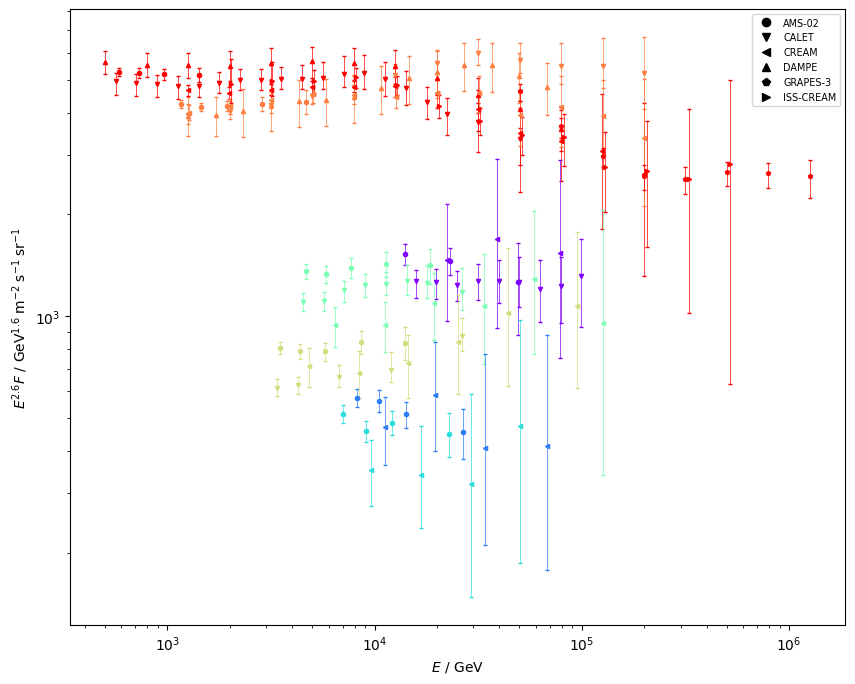

In [3]:
fit_data.plot(scale=2.6);

In [4]:
from bayesian_analysis import FitConfig, PlotsConfig, run_ml_analysis
from cr_knee_fit.cr_model import CosmicRaysModelConfig, SpectralBreakConfig
from cr_knee_fit.elements import Element
from cr_knee_fit.guesses import initial_guess_one_population_model
from cr_knee_fit.model_ import ModelConfig

bestfit, gof = run_ml_analysis(
    fit_data=fit_data,
    config=FitConfig.from_guessing_func(
        name="element-balance",
        fit_data=fit_data.config,
        mcmc=None,
        plots=PlotsConfig(),
        generate_guess=lambda: initial_guess_one_population_model(
            ModelConfig(
                cr_model_config=CosmicRaysModelConfig(
                    components=[[el] for el in Element.regular()],
                    breaks=[
                        SpectralBreakConfig(
                            fixed_lg_sharpness=0.7,
                            is_softening=True,
                            lg_break_prior_limits=(3.5, 4.5),
                        ),
                        SpectralBreakConfig(
                            fixed_lg_sharpness=0.7,
                            is_softening=False,
                            lg_break_prior_limits=(4.5, 5.5),
                        ),
                    ],
                ),
                shifted_experiments=fit_data.config.experiments_spectrum,
            )
        ),
    ),
    freeze_shifts=False,
)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 61.84606511931642
             x: [-4.103e+00  2.618e+00 ... -1.194e-02  7.945e-04]
           nit: 9398
          nfev: 11719
 final_simplex: (array([[-4.103e+00,  2.618e+00, ..., -1.194e-02,
                         7.945e-04],
                       [-4.103e+00,  2.618e+00, ..., -1.194e-02,
                         7.945e-04],
                       ...,
                       [-4.103e+00,  2.618e+00, ..., -1.194e-02,
                         7.945e-04],
                       [-4.103e+00,  2.618e+00, ..., -1.194e-02,
                         7.945e-04]]), array([ 6.185e+01,  6.185e+01, ...,  6.185e+01,  6.185e+01]))
Goodness of fit: GoodnessOfFit(max_logpost=np.float64(-61.84606511931642), loglike_at_map=-77.6216783543431, ndim=24, aic=np.float64(171.69213023863284))


In [5]:
print(gof)

GoodnessOfFit(max_logpost=np.float64(-61.84606511931642), loglike_at_map=-77.6216783543431, ndim=24, aic=np.float64(171.69213023863284))


In [6]:
validation_data = Data.load(config=DataConfig(experiments_all_particle=[experiments.hawc]))

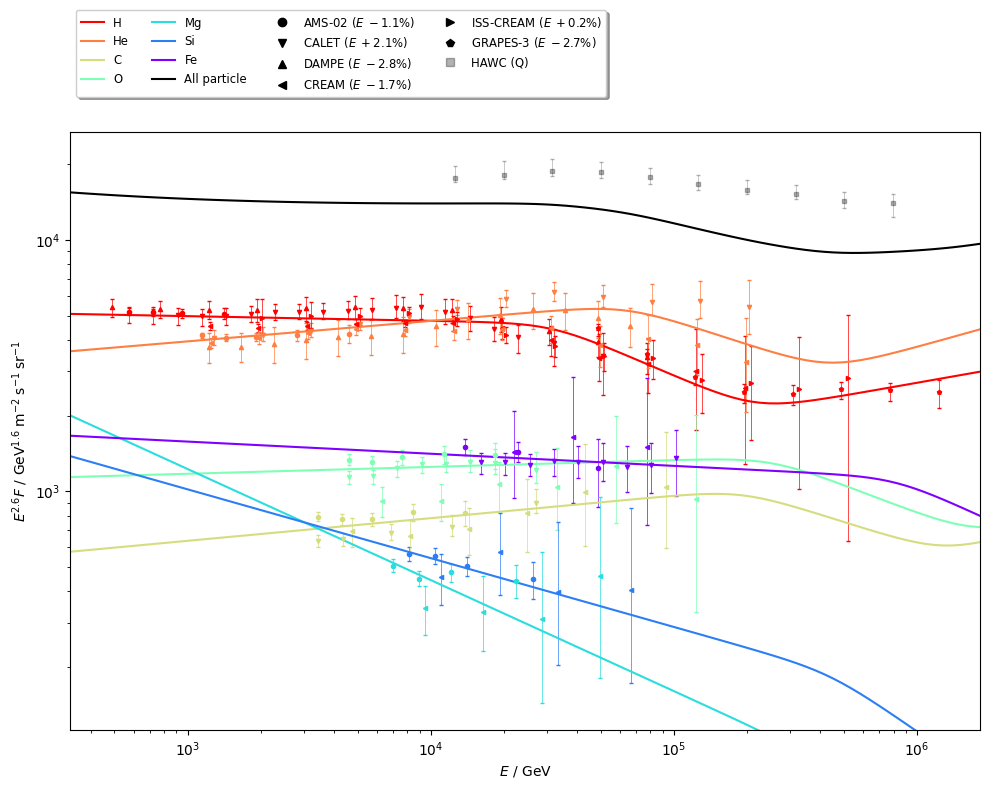

In [7]:
assert bestfit is not None
bestfit.plot_spectra(
    fit_data=fit_data,
    scale=2.6,
    validation_data=validation_data,
);

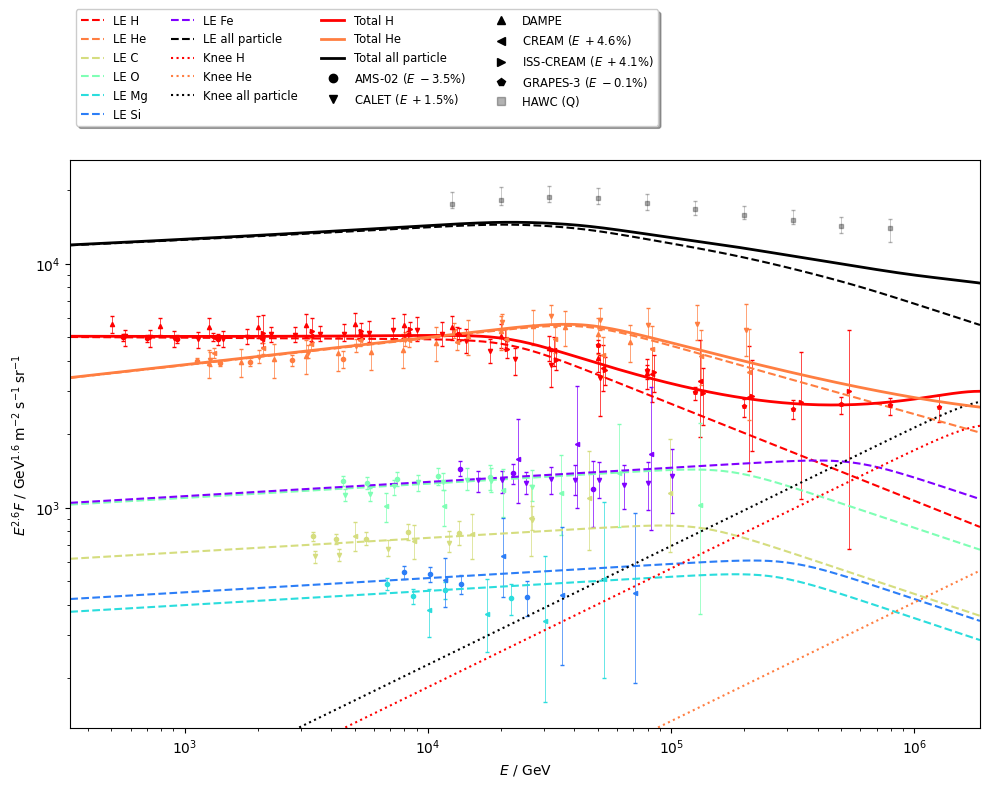

In [8]:
from pathlib import Path

from cr_knee_fit.model_ import Model

twopop_dir = Path("out/2pop/")
twopop_fit_config = FitConfig.model_validate_json((twopop_dir / "config-dump.json").read_text())
twopop_model_best = Model.load(twopop_dir / "posterior-ml.txt", layout_info=twopop_fit_config.model)
assert twopop_model_best is not None
twopop_model_best.energy_shifts.lg_shifts[experiments.hawc] = 0
twopop_model_best.plot_spectra(
    fit_data=fit_data,
    scale=2.6,
    validation_data=validation_data,
);

In [9]:
hawc_allpart = validation_data.all_particle_spectra[experiments.hawc]

In [10]:
for E, F in zip(hawc_allpart.E, hawc_allpart.F):
    E_TeV = E / 1000
    if E_TeV > 100:
        continue
    ref = twopop_model_best
    # ref = bestfit
    pred = ref.compute_spectrum(E=E, element=None)
    ratio = F / pred
    print(E_TeV, ratio)

12.59 1.2131025880303172
19.95 1.2291652269354092
31.62 1.2797849931209395
50.12 1.3194178560366008
79.43 1.3419124262820263
